In [1]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [2]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train_labels = train_transaction[["TransactionID","isFraud"]]

In [6]:
train_transaction = train_transaction.merge(train_identity,on="TransactionID",how='outer')
test_transaction = test_transaction.merge(test_identity,on="TransactionID",how='outer')

In [7]:
for (columnName, columnData) in test_transaction.iteritems():
    print(columnName)

TransactionID
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V1

In [8]:
categorias = train_transaction[['isFraud','ProductCD', 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5', 'card6', 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38']]

train_transaction = train_transaction.drop(columns =['ProductCD', 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5', 'card6', 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38'] )

In [9]:
test_transaction.columns = test_transaction.columns.str.replace('id-','id_')

In [10]:
for (columnName, columnData) in categorias.iteritems():
    if columnName != 'isFraud':
       aux = categorias.groupby([columnName])['isFraud'].mean().to_dict()
       categorias[columnName] =  categorias[columnName].map(aux)
       test_transaction[columnName] = test_transaction[columnName].map(aux)

In [11]:
categorias[["isFraud"]]==train_transaction[["isFraud"]]

,isFraud
0,True
1,True
2,True
3,True
4,True
...,...
590535,True
590536,True
590537,True
590538,True


In [12]:
categorias.head()

,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,0,0.020399,0.232558,NaN,0.024568,0.077282,0.043321,0.066785,0.017809,0.023972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.020399,0.046852,0.065118,0.024568,0.034331,0.062945,0.066785,0.025426,0.023972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.020399,0.008123,0.024014,0.024568,0.034756,0.011026,0.024263,0.031955,0.023972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.020399,0.014018,0.016295,0.024568,0.034331,0.013646,0.024263,0.031652,0.023972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.047662,0.055556,0.046214,0.024568,0.034331,0.062945,0.066785,0.032672,0.023972,...,0.051338,0.05782,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [13]:
categorias = categorias.drop(columns =["isFraud"] )

In [14]:
train_transaction = train_transaction.join(categorias)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,2987000,0,86400,68.5,19.0,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,NaN,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,287.0,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,NaN,NaN,2.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,NaN,NaN,1.0,1.0,0.0,0.0,...,0.051338,0.05782,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [15]:
##########################################################################################################################

In [16]:
train_transaction = train_transaction.fillna(0)
test_transaction = test_transaction.fillna(0)

In [17]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,2987000,0,86400,68.5,19.0,0.0,1.0,1.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2987001,0,86401,29.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2987002,0,86469,59.0,287.0,0.0,1.0,1.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2987003,0,86499,50.0,0.0,0.0,2.0,5.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2987004,0,86506,50.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.051338,0.05782,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [18]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,0.020399,0.000000,0.021641,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.00,0.020399,0.024194,0.021641,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.00,0.020399,0.000000,0.000000,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3663552,18403310,284.95,0.020399,0.002765,0.010402,0.024568,0.034756,0.011026,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.95,0.020399,0.009560,0.008918,0.024568,0.034331,0.013646,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#df_test_encoding = df_test_encoding.iloc[:,1:]
X = train_transaction.iloc[:, 2:]
y = train_labels.iloc[:, 1:]

In [20]:
X.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,86400,68.5,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,86401,29.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,86469,59.0,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,86499,50.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,86506,50.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.051338,0.05782,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [22]:
X_test.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
470624,12153579,724.000,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565820,15005886,108.500,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284083,6970178,47.950,6.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239689,5673658,100.599,0.0,0.0,2.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281855,6886780,107.950,0.0,0.0,10.0,14.0,0.0,0.0,11.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":['none',"l1","l2"]}
logisticRegr = LogisticRegression()
logisticRegr_cv=GridSearchCV(logisticRegr,grid,cv=10)
logisticRegr.fit(X_train, y_train)

C:\Users\Pato\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Pato\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
prediccion = logisticRegr.predict(X_test)

In [25]:
f1_score(y_test, prediccion, average ='micro')

0.9636519118095302

In [26]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, logisticRegr.predict_proba(X_test)[:,1])
print(auc)

0.5065208682682532


In [29]:
auc = roc_auc_score(train_labels["isFraud"], logisticRegr.predict_proba(X)[:,1])
print(auc)

0.5039902220211215


In [30]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, prediccion)
print(precision)

0.17721518987341772


In [31]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [32]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,0.020399,0.000000,0.021641,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.00,0.020399,0.024194,0.021641,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.00,0.020399,0.000000,0.000000,0.024568,0.034756,0.029516,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3663552,18403310,284.95,0.020399,0.002765,0.010402,0.024568,0.034756,0.011026,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.95,0.020399,0.009560,0.008918,0.024568,0.034331,0.013646,0.024263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
test_transaction = test_transaction.drop(columns=["TransactionID"])

In [34]:
prediccion_logistica = (logisticRegr.predict(test_transaction))

In [35]:
submission_format = pd.read_csv('sample_submission.csv', index_col='TransactionID')
my_submission = pd.DataFrame(data=prediccion_logistica,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [36]:
my_submission.head()

,isFraud
TransactionID,
3663549,0
3663550,0
3663551,0
3663552,0
3663553,0


In [38]:
my_submission.to_csv('parte2_training-result.csv',index= True)

In [39]:
import seaborn as sns

In [40]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediccion)
cnf_matrix

array([[113801,     65],
       [  4228,     14]], dtype=int64)

In [41]:
len(logisticRegr.coef_[0])

432

In [42]:
import matplotlib.pyplot as plt

In [43]:
importance = logisticRegr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00104
Feature: 2, Score: -0.00043
Feature: 3, Score: -0.00006
Feature: 4, Score: -0.00012
Feature: 5, Score: -0.00011
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00004
Feature: 8, Score: -0.00006
Feature: 9, Score: -0.00009
Feature: 10, Score: -0.00003
Feature: 11, Score: -0.00005
Feature: 12, Score: -0.00004
Feature: 13, Score: -0.00006
Feature: 14, Score: -0.00010
Feature: 15, Score: -0.00004
Feature: 16, Score: -0.00034
Feature: 17, Score: -0.00009
Feature: 18, Score: -0.00089
Feature: 19, Score: -0.00088
Feature: 20, Score: -0.00016
Feature: 21, Score: -0.00083
Feature: 22, Score: -0.00019
Feature: 23, Score: -0.00002
Feature: 24, Score: -0.00002
Feature: 25, Score: -0.00022
Feature: 26, Score: -0.00000
Feature: 27, Score: -0.00100
Feature: 28, Score: -0.00047
Feature: 29, Score: 0.00001
Feature: 30, Score: -0.00001
Feature: 31, Score: 0.00002
Feature: 32, Score: -0.00121
Feature: 33, Score: -0.00000
Feature: 34, Score: -0.000

In [44]:
df1 = X.iloc[:,0:87]
importance1 = importance[0:87]
df2 = X.iloc[:,87:174]
importance2 = importance[87:174]
df3 = X.iloc[:,174:261]
importance3 = importance[174:261]
df4 = X.iloc[:,261:348]
importance4 = importance[261:348]
df5 = X.iloc[:,348:432]
importance5 = importance[348:432]
#plt.figure(figsize=(100,100))
#plt.barh(X.columns, importance)
#plt.show()

In [45]:
df1.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54
0,86400,68.5,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,86401,29.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,86499,50.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,86506,50.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df2.head()

,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,...,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df3.head()

,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,...,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,6.0,18.0,140.0,0.0,0.0,0.0,0.0,1803.0,49.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
df4.head()

,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,...,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df5.head()

,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051338,0.05782,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


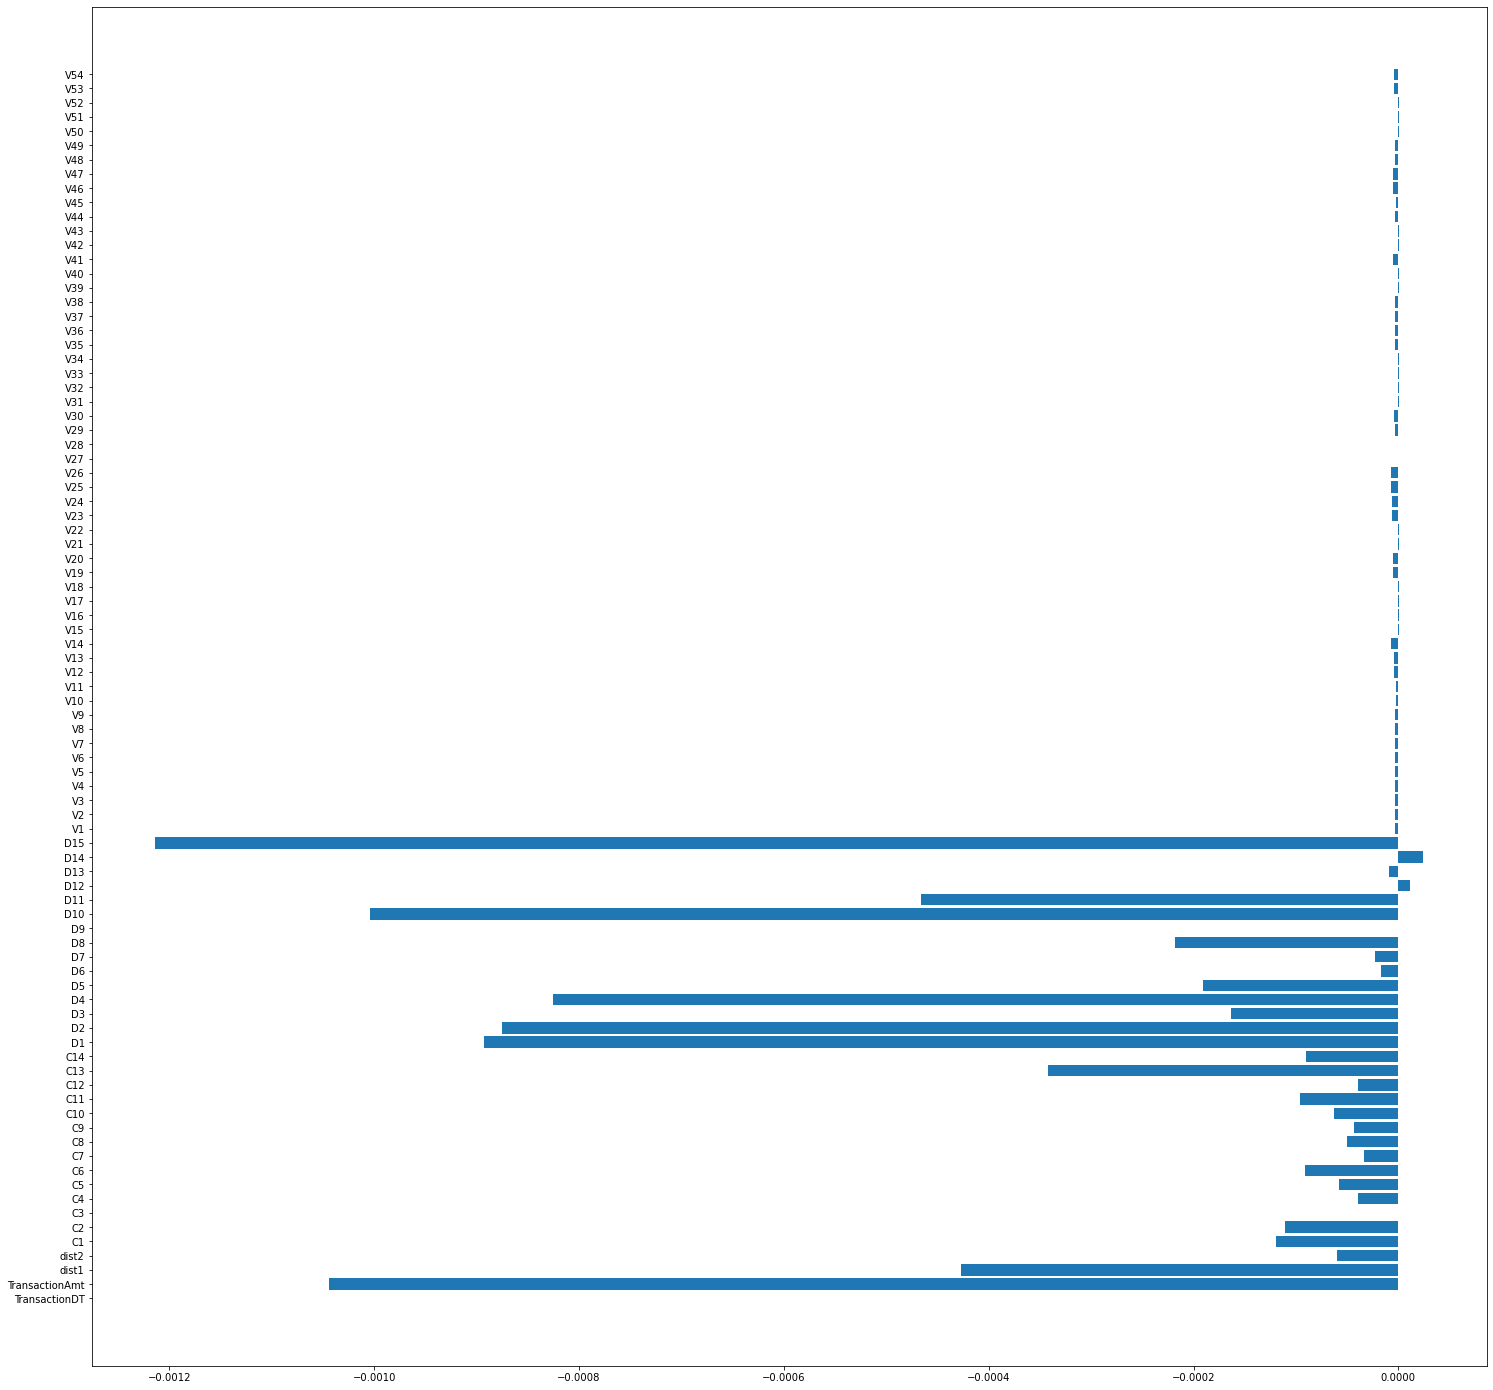

In [50]:
plt.figure(figsize=(25,25))
plt.barh(df1.columns, importance1)
plt.show()

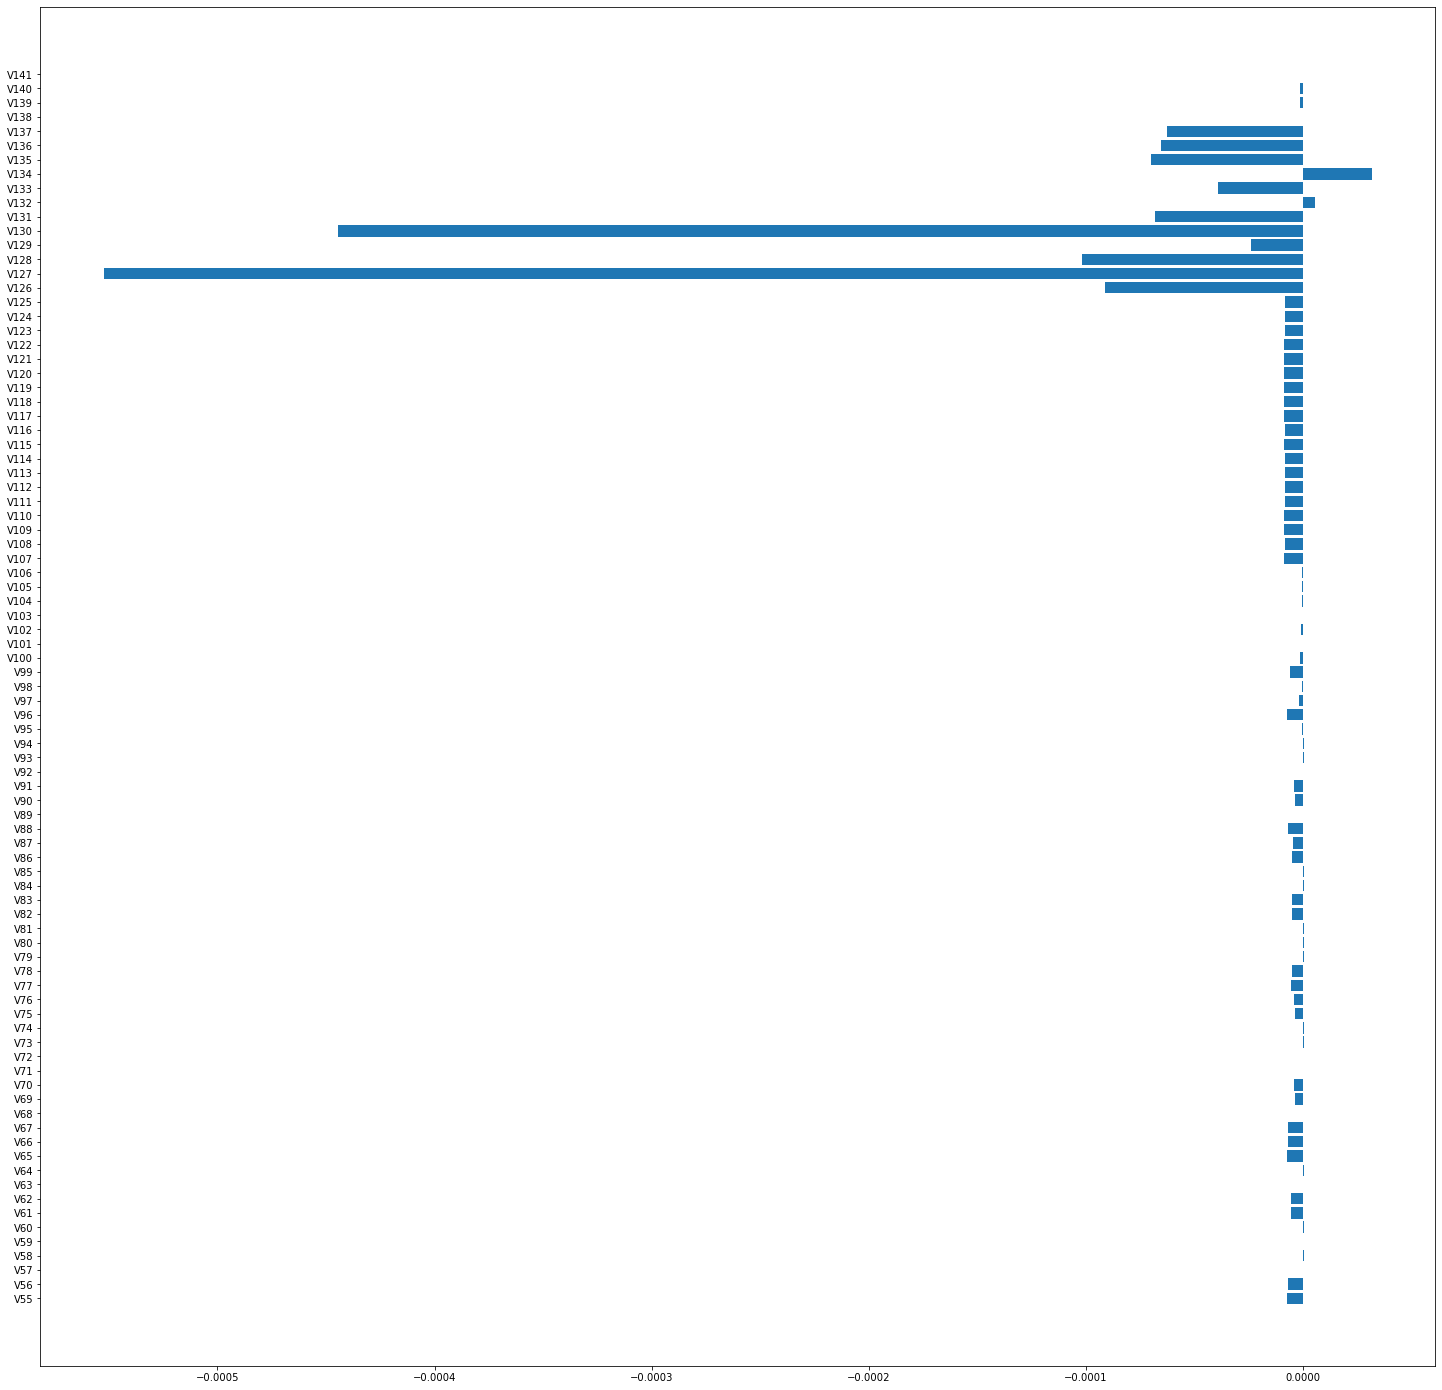

In [51]:
plt.figure(figsize=(25,25))
plt.barh(df2.columns, importance2)
plt.show()

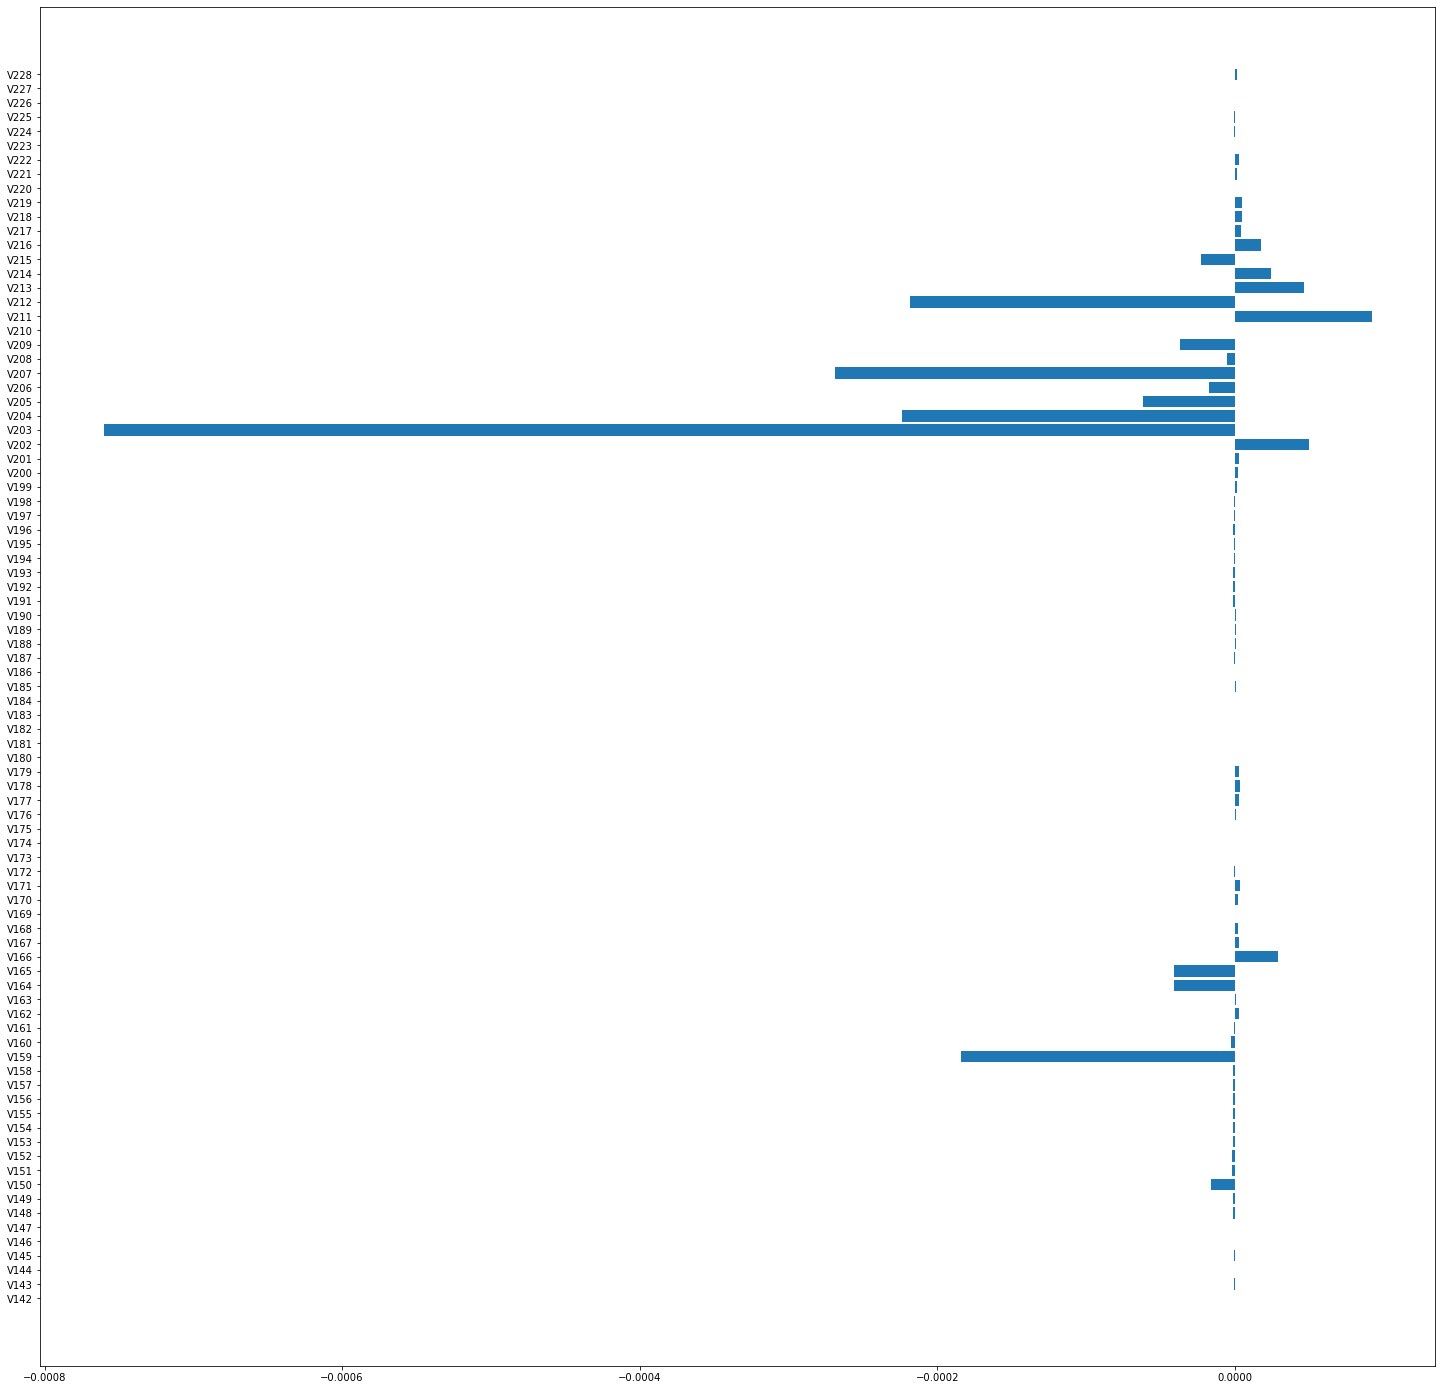

In [52]:
plt.figure(figsize=(25,25))
plt.barh(df3.columns, importance3)
plt.show()

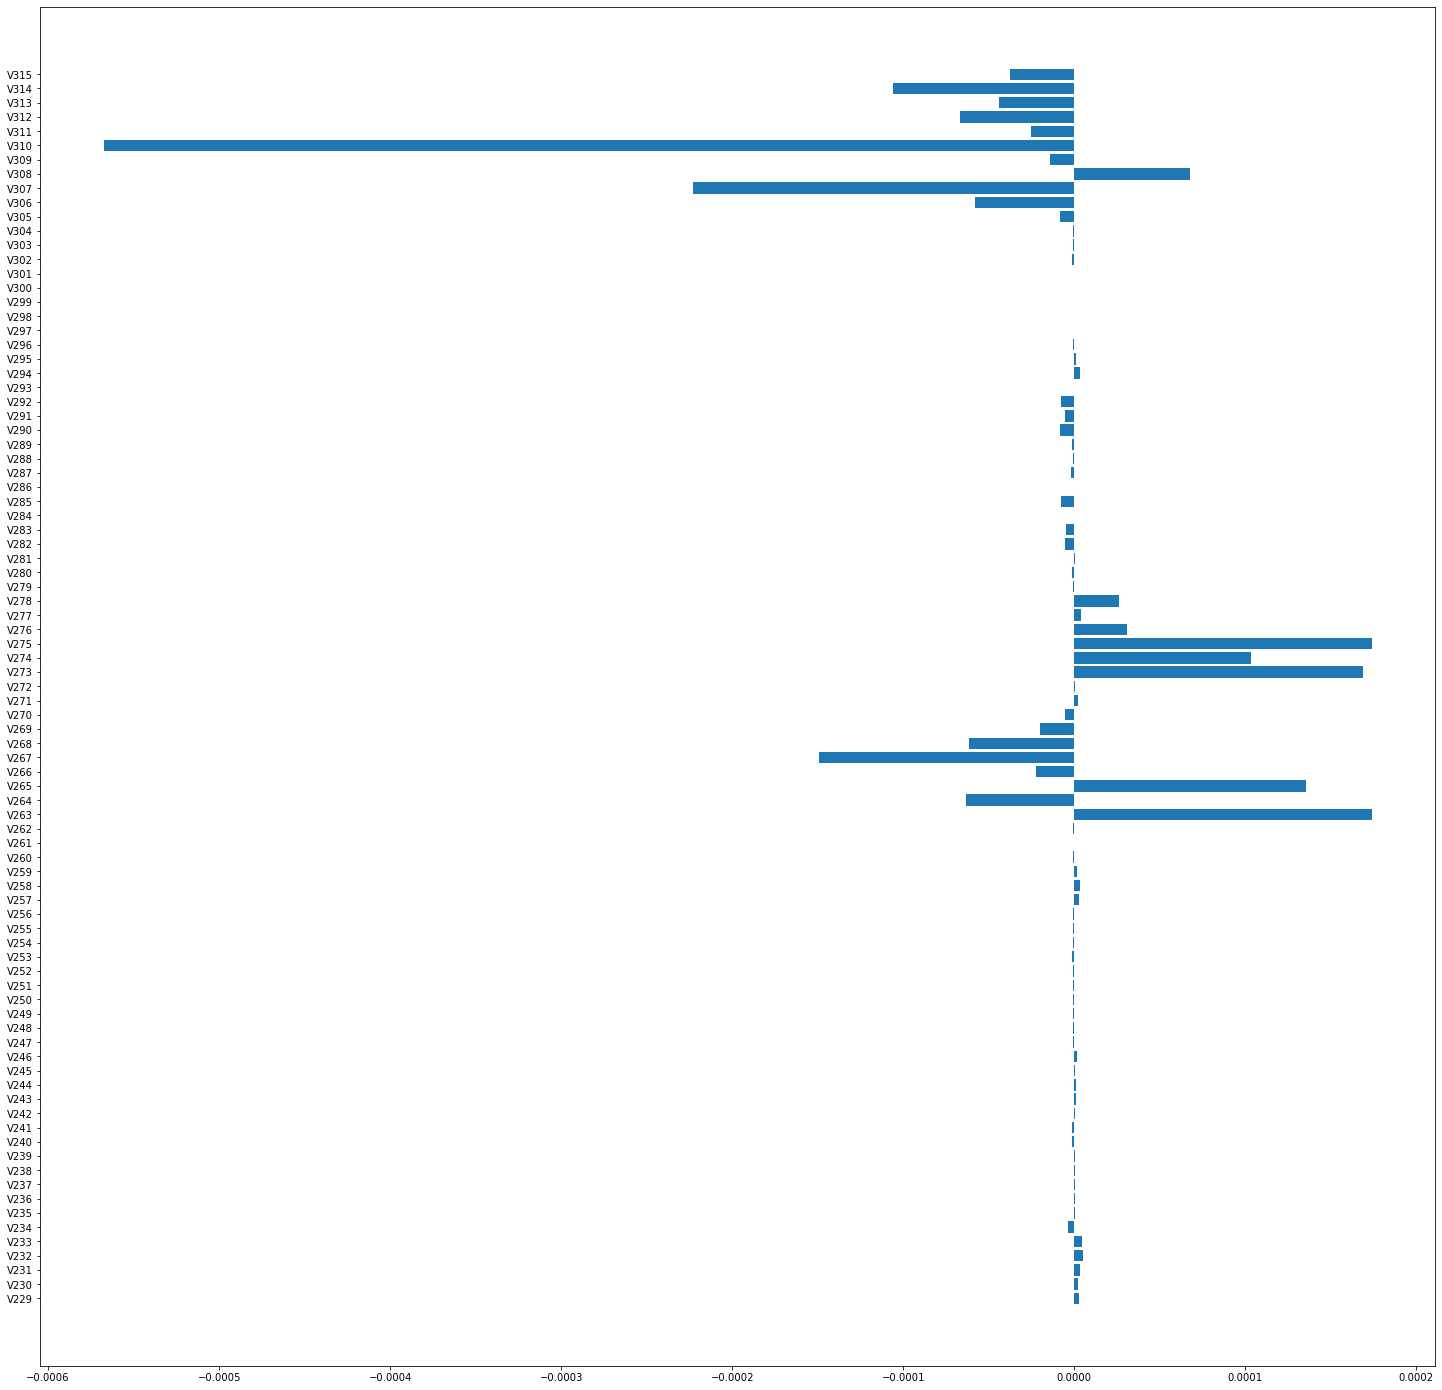

In [53]:
plt.figure(figsize=(25,25))
plt.barh(df4.columns, importance4)
plt.show()

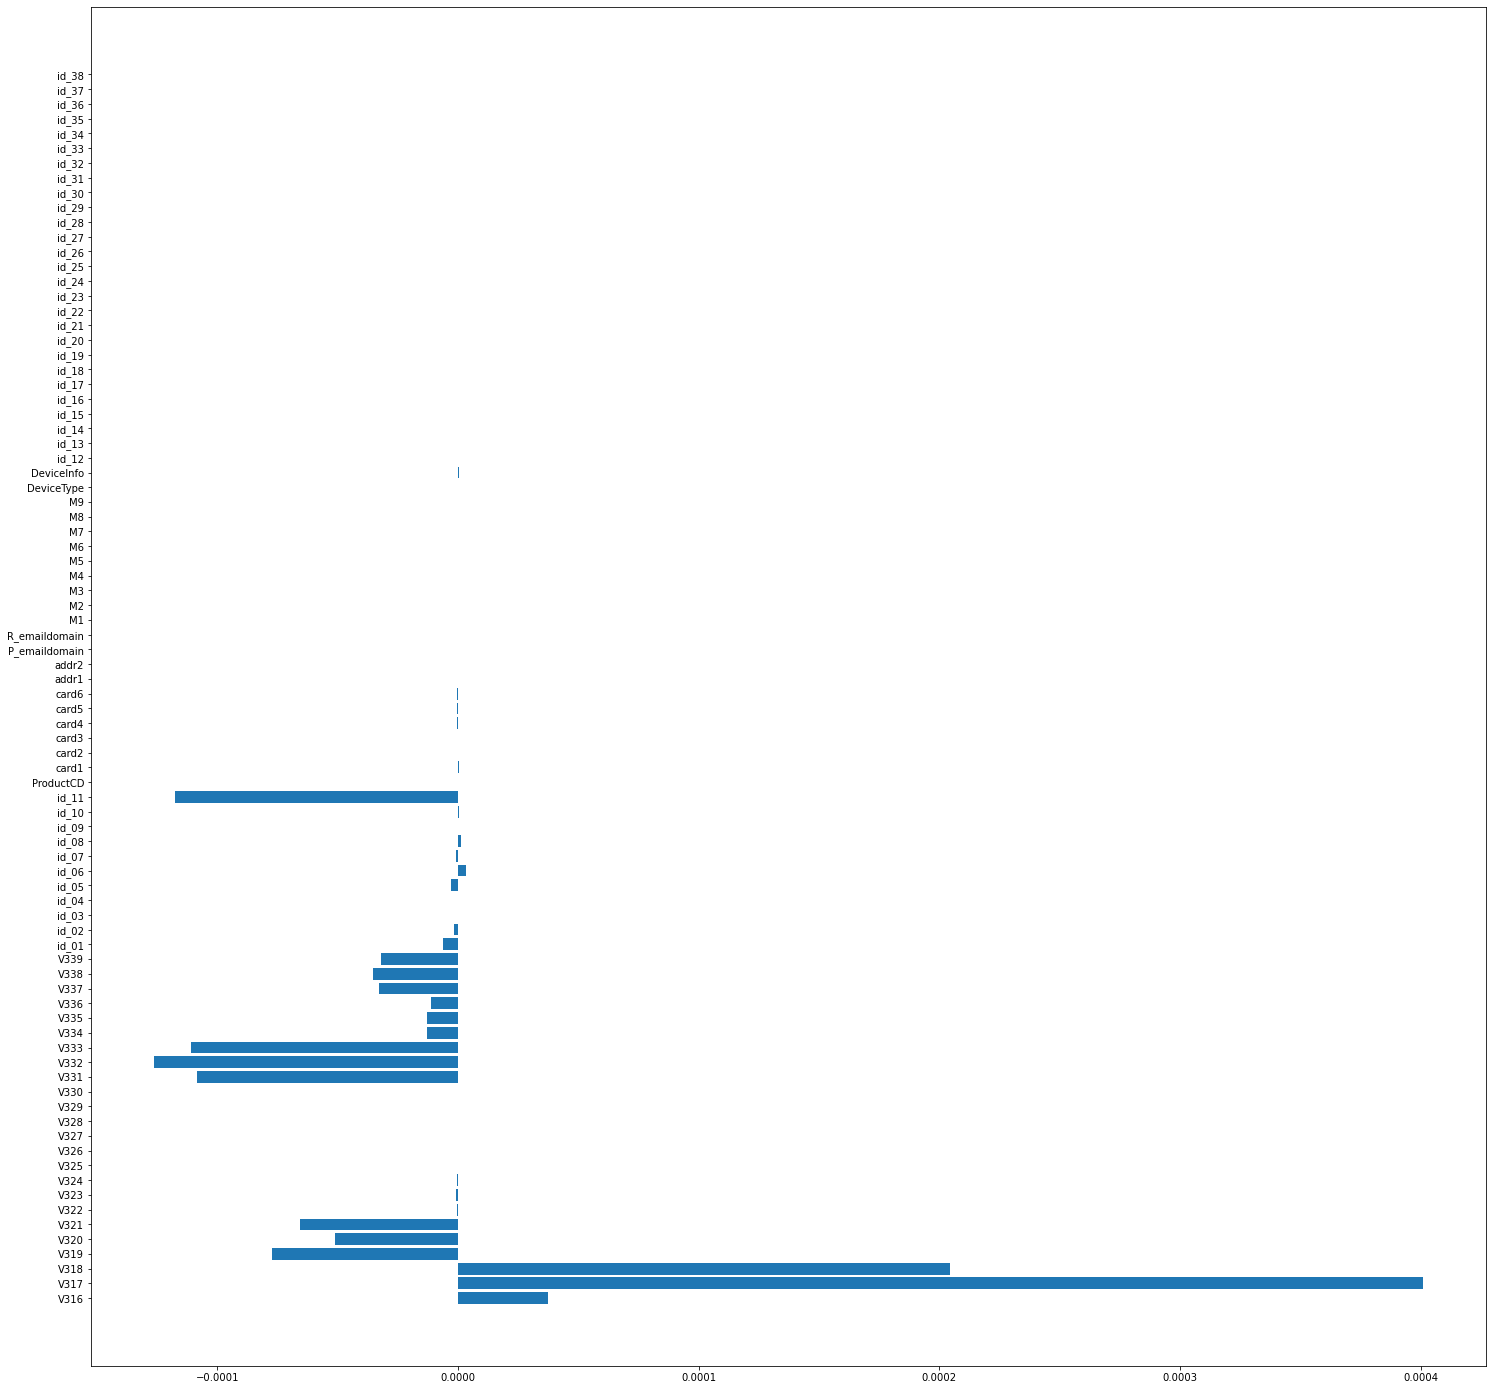

In [54]:
plt.figure(figsize=(25,25))
plt.barh(df5.columns, importance5)
plt.show()